In [1]:
# Selecting libraries
import nbformat
import yfinance as yf
import pandas as pd
import numpy as np
import pyfolio as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
warnings.filterwarnings("ignore")

c:\Users\josh\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyfolio\pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# Define portfolio allocations
allocations_A = {'Equities': 0.50, 'HighYieldBonds': 0.00, 'InvGradeBonds': 0.50}
allocations_B = {'Equities': 0.40, 'HighYieldBonds': 0.10, 'InvGradeBonds': 0.50}
allocations_C = {'Equities': 0.50, 'HighYieldBonds': 0.10, 'InvGradeBonds': 0.40}
allocations_D = {'Equities': 0.45, 'HighYieldBonds': 0.10, 'InvGradeBonds': 0.45}

# Create a DataFrame using the allocation variables
allocations_df = pd.DataFrame({
    'Asset': ['Equities', 'HighYieldBonds', 'InvGradeBonds'],
    'Index': ['SPX', 'Bloomberg HighYield', 'Bloomberg Agg'],
    'Baseline': [allocations_A['Equities'], allocations_A['HighYieldBonds'], allocations_A['InvGradeBonds']],
    'JS_Strategy': [allocations_B['Equities'], allocations_B['HighYieldBonds'], allocations_B['InvGradeBonds']],
    'JB_Strategy': [allocations_C['Equities'], allocations_C['HighYieldBonds'], allocations_C['InvGradeBonds']],
    'JE_Strategy': [allocations_D['Equities'], allocations_D['HighYieldBonds'], allocations_D['InvGradeBonds']]
})
allocations_df

,Asset,Index,Baseline,JS_Strategy,JB_Strategy,JE_Strategy
0,Equities,SPX,0.5,0.4,0.5,0.45
1,HighYieldBonds,Bloomberg HighYield,0.0,0.1,0.1,0.10
2,InvGradeBonds,Bloomberg Agg,0.5,0.5,0.4,0.45


In [3]:
equity = pd.read_csv('./Cleaned_Data/SPX.csv')
highyield = pd.read_csv('./Cleaned_Data/highyield.csv')
safebond = pd.read_csv('./Cleaned_Data/safebond.csv')

equity['Dates'] = pd.to_datetime(equity['Dates'])
highyield['Dates'] = pd.to_datetime(highyield['Dates'])
safebond['Dates'] = pd.to_datetime(safebond['Dates'])

start_date = '1983-08-01'
end_date = '2024-06-25'

In [4]:
# Define portfolio allocations
allocations_A = {'Equities': 0.50, 'HighYieldBonds': 0.00, 'InvGradeBonds': 0.50}
allocations_B = {'Equities': 0.40, 'HighYieldBonds': 0.10, 'InvGradeBonds': 0.50}
allocations_C = {'Equities': 0.50, 'HighYieldBonds': 0.10, 'InvGradeBonds': 0.40}
allocations_D = {'Equities': 0.45, 'HighYieldBonds': 0.10, 'InvGradeBonds': 0.45}

# Create a DataFrame using the allocation variables
allocations_df = pd.DataFrame({
    'Asset': ['Equities', 'HighYieldBonds', 'InvGradeBonds'],
    'Index': ['SPX', 'Bloomberg HighYield', 'Bloomberg Agg'],
    'Baseline': [allocations_A['Equities'], allocations_A['HighYieldBonds'], allocations_A['InvGradeBonds']],
    'JS_Strategy': [allocations_B['Equities'], allocations_B['HighYieldBonds'], allocations_B['InvGradeBonds']],
    'JB_Strategy': [allocations_C['Equities'], allocations_C['HighYieldBonds'], allocations_C['InvGradeBonds']],
    'JE_Strategy': [allocations_D['Equities'], allocations_D['HighYieldBonds'], allocations_D['InvGradeBonds']]
})
allocations_df

,Asset,Index,Baseline,JS_Strategy,JB_Strategy,JE_Strategy
0,Equities,SPX,0.5,0.4,0.5,0.45
1,HighYieldBonds,Bloomberg HighYield,0.0,0.1,0.1,0.10
2,InvGradeBonds,Bloomberg Agg,0.5,0.5,0.4,0.45


To arrive at the aftertax figures, we assumed the investor sold everything in the taxable account, 
generating capital gains at 15%, and withdrew all assets from the tax-sheltered account, requiring 
regular income taxes at the assumed 22% rate. This simplified aftertax calculation could not occur in the 
real world. Scenario 2, for instance, would be heavily penalized under these assumptions for a couple of 
reasons. First, withdrawing $737,902 immediately out of a tax-deferred account puts an investor in the 
current highest possible tax bracket. This is doubly penalizing because it then bumps up the capital 
gains tax rate on the $300,000 taxable account to 20% from 15%. Yet it is unlikely that investors would 
withdraw their invested assets out of the market and retirement accounts all at once. As such, the 22% 
income and 15% capital gains tax rates reflect the more likely reality that investors face

In [5]:
ret = pd.read_csv('./Output/semi_annual_portfolio_daily_returns.csv')
ret['Date'] = pd.to_datetime(ret['Date'])

# # create annualized return for each strategy
# BS_ann_ret = np.mean(ret["Baseline"]) * 252 * 100
# JS_ann_ret = np.mean(ret["JS_Strategy"]) * 252 * 100
# JB_ann_ret = np.mean(ret["JB_Strategy"]) * 252 * 100
# JE_ann_ret = np.mean(ret["JE_Strategy"]) * 252 * 100
# # keep 2 decimal places
# print(f'BS_ann_ret: {BS_ann_ret:.2f}')
# print(f'JS_ann_ret: {JS_ann_ret:.2f}')
# print(f'JB_ann_ret: {JB_ann_ret:.2f}')
# print(f'JE_ann_ret: {JE_ann_ret:.2f}')

In [6]:
def backtest_portfolios_asset_class_ret(allocations_df, backtest_start_date, backtest_end_date, spy=equity, jnk=highyield, agg=safebond, rebalance_freq='M'):
    cumulative_product_dict = {}
    portfolio_daily_returns_dict = {}
    asset_class_daily_returns_dict = {}

    for allocation_name in allocations_df.columns[2:]:  # Skip 'Asset' and 'ETFs' columns
        # Extract the allocation values from allocations_df
        allocations = {
            'Equities': allocations_df.loc[allocations_df['Asset'] == 'Equities', allocation_name].values[0],
            'HighYieldBonds': allocations_df.loc[allocations_df['Asset'] == 'HighYieldBonds', allocation_name].values[0],
            'InvGradeBonds': allocations_df.loc[allocations_df['Asset'] == 'InvGradeBonds', allocation_name].values[0]
        }

        agg.ffill(inplace=True)
        jnk.ffill(inplace=True)
        spy.ffill(inplace=True)
        # Filter the data for the backtest period
        agg_backtest = agg[(agg['Dates'] >= backtest_start_date) & (agg['Dates'] <= backtest_end_date)].set_index('Dates')
        jnk_backtest = jnk[(jnk['Dates'] >= backtest_start_date) & (jnk['Dates'] <= backtest_end_date)].set_index('Dates')
        spy_backtest = spy[(spy['Dates'] >= backtest_start_date) & (spy['Dates'] <= backtest_end_date)].set_index('Dates')

        # Align the indices
        combined_index = agg_backtest.index.intersection(jnk_backtest.index).intersection(spy_backtest.index)
        agg_backtest = agg_backtest.loc[combined_index]
        jnk_backtest = jnk_backtest.loc[combined_index]
        spy_backtest = spy_backtest.loc[combined_index]

        # Initialize portfolio values and weights
        portfolio_value = 1.0
        portfolio_values = [portfolio_value]
        portfolio_daily_returns = []
        asset_class_daily_returns = {'Equities': [], 'HighYieldBonds': [], 'InvGradeBonds': []}

        # Initialize weights
        weights = np.array([allocations['Equities'], allocations['HighYieldBonds'], allocations['InvGradeBonds']])

        # Rebalance dates based on the specified frequency
        rebalance_dates = pd.date_range(start=backtest_start_date, end=backtest_end_date, freq=rebalance_freq)

        for i, date in enumerate(combined_index):
            if date in rebalance_dates:
                # Rebalance the portfolio
                total_value = (
                    weights[0] * spy_backtest.loc[date]['LAST_PRICE'] +
                    weights[1] * jnk_backtest.loc[date]['LAST_PRICE'] +
                    weights[2] * agg_backtest.loc[date]['LAST_PRICE']
                )
                weights = np.array([
                    allocations['Equities'] * total_value / spy_backtest.loc[date]['LAST_PRICE'],
                    allocations['HighYieldBonds'] * total_value / jnk_backtest.loc[date]['LAST_PRICE'],
                    allocations['InvGradeBonds'] * total_value / agg_backtest.loc[date]['LAST_PRICE']
                ])
                weights /= weights.sum()  # Normalize weights to sum to 1

            if i > 0:  # Skip the first day
                # Calculate portfolio return
                daily_returns = np.array([
                    spy_backtest.loc[date]['DailyReturn'],
                    jnk_backtest.loc[date]['DailyReturn'],
                    agg_backtest.loc[date]['DailyReturn']
                ])
                portfolio_return = np.dot(weights, daily_returns)
                portfolio_value *= (1 + portfolio_return)

                portfolio_values.append(portfolio_value)
                portfolio_daily_returns.append(portfolio_return)

                # Store weighted daily returns of each asset class
                asset_class_daily_returns['Equities'].append(weights[0] * spy_backtest.loc[date]['DailyReturn'])
                asset_class_daily_returns['HighYieldBonds'].append(weights[1] * jnk_backtest.loc[date]['DailyReturn'])
                asset_class_daily_returns['InvGradeBonds'].append(weights[2] * agg_backtest.loc[date]['DailyReturn'])

        cumulative_product_dict[allocation_name] = pd.Series(portfolio_values, index=[pd.to_datetime(backtest_start_date)] + list(combined_index[1:]))
        portfolio_daily_returns_dict[allocation_name] = pd.Series(portfolio_daily_returns, index=combined_index[1:])
        asset_class_daily_returns_dict[allocation_name] = pd.DataFrame(asset_class_daily_returns, index=combined_index[1:])

    return asset_class_daily_returns_dict

In [7]:
asset_class_daily_returns_df = backtest_portfolios_asset_class_ret(allocations_df, start_date, end_date, rebalance_freq='6M')

In [8]:
all_returns_df = pd.concat(asset_class_daily_returns_df, axis=1, keys=asset_class_daily_returns_df.keys())

# # Print the combined DataFrame
# all_returns_df.to_csv('./Output/asset_class_daily_returns_df.csv')

In [9]:
# Calculate annualized return for each asset class in each allocation strategy
annual_returns = {}

for strategy, df in asset_class_daily_returns_df.items():
    annual_returns[strategy] = {
        'Equities': np.mean(df['Equities']) * 252 * 100,
        'HighYieldBonds': np.mean(df['HighYieldBonds']) * 252 * 100,
        'InvGradeBonds': np.mean(df['InvGradeBonds']) * 252 * 100
    }

# Print the annualized returns
for strategy, returns in annual_returns.items():
    print(f"{strategy} Annual Returns:")
    for asset_class, annual_return in returns.items():
        print(f"  {asset_class}: {annual_return:.4f}%")

Baseline Annual Returns:
  Equities: 3.6948%
  HighYieldBonds: 0.0000%
  InvGradeBonds: 2.0265%
JS_Strategy Annual Returns:
  Equities: 2.8645%
  HighYieldBonds: 0.8132%
  InvGradeBonds: 1.9150%
JB_Strategy Annual Returns:
  Equities: 3.5316%
  HighYieldBonds: 0.7995%
  InvGradeBonds: 1.5220%
JE_Strategy Annual Returns:
  Equities: 3.1996%
  HighYieldBonds: 0.8061%
  InvGradeBonds: 1.7177%


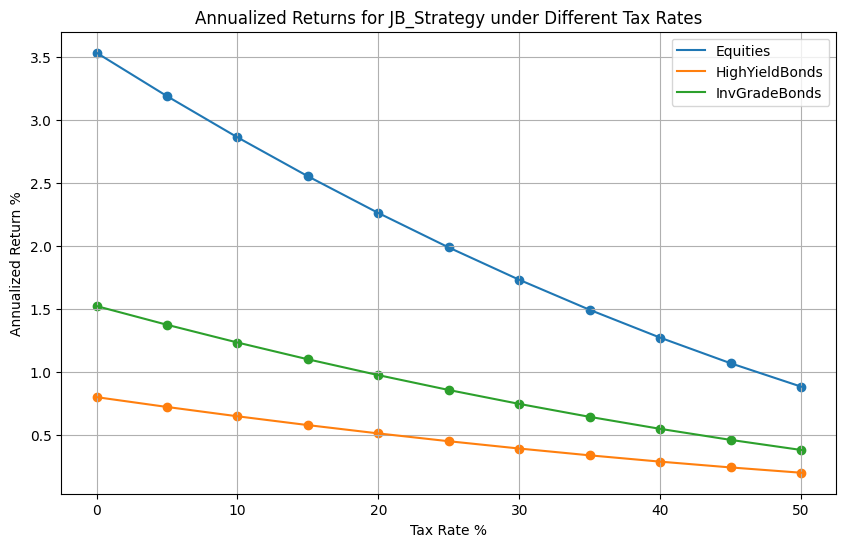

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Define the tax rates to consider
tax_rates = np.arange(0, 51, 5)  # From 0% to 50% in steps of 5%

# Function to calculate after-tax returns
def calculate_after_tax_return(pre_tax_return, tax_rate):
    capital_gains_tax_rate = tax_rate / 100
    regular_income_tax_rate = tax_rate / 100
    after_tax_return = pre_tax_return * (1 - capital_gains_tax_rate) * (1 - regular_income_tax_rate)
    return after_tax_return

# Get the pre-tax annual returns for JB_Strategy
pre_tax_returns = annual_returns['JB_Strategy']

# Calculate after-tax returns for each tax rate
after_tax_returns = {asset_class: [] for asset_class in pre_tax_returns.keys()}
for tax_rate in tax_rates:
    for asset_class, pre_tax_return in pre_tax_returns.items():
        after_tax_return = calculate_after_tax_return(pre_tax_return, tax_rate)
        after_tax_returns[asset_class].append(after_tax_return)

# Plot the results
plt.figure(figsize=(10, 6))
for asset_class, returns in after_tax_returns.items():
    plt.plot(tax_rates, returns, label=asset_class)
    plt.scatter(tax_rates, returns)  # Add dots to the plot

plt.xlabel('Tax Rate %')
plt.ylabel('Annualized Return %')
plt.title('Annualized Returns for JB_Strategy under Different Tax Rates')
plt.legend()
plt.grid(True)
plt.show()

From a pure tax-management standpoint, the “right” asset-location answers seem simple. Bonds spin off regular income payments that are taxed at ordinary tax rates, while the dividend payments from equities and equity funds are taxed at the same lower rates that apply to long-term capital gains, provided the dividends are qualified. From that perspective, **fixed-income securities make the most sense in taxsheltered accounts, where their regular distributions can be reinvested and compounded without
taxation until withdrawal time, while equities are better suited for taxable accounts.** 


Take JB_Strategy as an example, and set up the starting investment of 100,000, and apply the different asset classes in to the different kind of taxable, non-taxable accounts:

Assuming an approximate 40-year investment/retirement period

In [ ]:
# compare different effect of allocating the 

Option 1:
- Tax-Sheltered Account: High-Yield Bonds, Equities
- Taxable Account: Investment-Grade Bonds

Option 2: #
- Tax-Sheltered Account: High-Yield Bonds, Investment-Grade Bonds
- Taxable Account: Equities

Option 3:
- Tax-Sheltered Account: Equities, Investment-Grade Bonds
- Taxable Account: High-Yield Bonds

Option 4: #
- Tax-Sheltered Account: High-Yield Bonds
- Taxable Account: Equities, Investment-Grade Bonds

Option 5:
- Tax-Sheltered Account: Equities
- Taxable Account: High-Yield Bonds, Investment-Grade Bonds

Option 6:
- Tax-Sheltered Account: Investment-Grade Bonds
- Taxable Account: High-Yield Bonds, Equities


Internal Revenue Service. for tax consideration
- Health Savings Accounts (HSA)
- 401K
- Roth IRA
- Taxable


Taxable Growth Prioritized: This scenario focuses on maximizing growth in the taxable account by holding more equities there and using tax-deferred assets to hold bonds. The taxable account starts entirely in equities, while the tax-deferred account balances with bonds.

Tax-Deferred Growth Prioritized: This scenario focuses on maximizing growth in the tax-deferred account by holding more equities there and using the taxable account to hold bonds. The tax-deferred account starts entirely in equities, while the taxable account balances with bonds.

Balanced: This scenario evenly splits the equities and bonds between the taxable and tax-deferred accounts, aiming for a balanced approach. Both accounts hold a mix of equities and bonds, equally divided.


From different allocation in different types of account, we can target on the investor types

- taxable brokerage account and a taxsheltered 401(k) account

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def backtest_portfolios_asset_class_cum_ret(allocations_df, backtest_start_date, backtest_end_date, spy=equity, jnk=highyield, agg=safebond, rebalance_freq='M', title=""):
    cumulative_product_dict = {}
    portfolio_daily_returns_dict = {}
    asset_class_returns_dict = {
        'Equities': {},
        'HighYieldBonds': {},
        'InvGradeBonds': {}
    }

    for allocation_name in allocations_df.columns[2:]:  # Skip 'Asset' and 'ETFs' columns
        # Extract the allocation values from allocations_df
        allocations = {
            'Equities': allocations_df.loc[allocations_df['Asset'] == 'Equities', allocation_name].values[0],
            'HighYieldBonds': allocations_df.loc[allocations_df['Asset'] == 'HighYieldBonds', allocation_name].values[0],
            'InvGradeBonds': allocations_df.loc[allocations_df['Asset'] == 'InvGradeBonds', allocation_name].values[0]
        }

        agg.ffill(inplace=True)
        jnk.ffill(inplace=True)
        spy.ffill(inplace=True)
        # Filter the data for the backtest period
        agg_backtest = agg[(agg['Dates'] >= backtest_start_date) & (agg['Dates'] <= backtest_end_date)].set_index('Dates')
        jnk_backtest = jnk[(jnk['Dates'] >= backtest_start_date) & (jnk['Dates'] <= backtest_end_date)].set_index('Dates')
        spy_backtest = spy[(spy['Dates'] >= backtest_start_date) & (spy['Dates'] <= backtest_end_date)].set_index('Dates')

        # Align the indices
        combined_index = agg_backtest.index.intersection(jnk_backtest.index).intersection(spy_backtest.index)
        agg_backtest = agg_backtest.loc[combined_index]
        jnk_backtest = jnk_backtest.loc[combined_index]
        spy_backtest = spy_backtest.loc[combined_index]

        # Initialize portfolio values and weights
        portfolio_value = 1.0
        portfolio_values = [portfolio_value]
        portfolio_daily_returns = []

        # Initialize weights
        weights = np.array([allocations['Equities'], allocations['HighYieldBonds'], allocations['InvGradeBonds']])

        # Rebalance dates based on the specified frequency
        rebalance_dates = pd.date_range(start=backtest_start_date, end=backtest_end_date, freq=rebalance_freq)

        # Initialize asset class values
        asset_class_values = {
            'Equities': allocations['Equities'],
            'HighYieldBonds': allocations['HighYieldBonds'],
            'InvGradeBonds': allocations['InvGradeBonds']
        }
        
        asset_class_returns = {
            'Equities': [allocations['Equities']],
            'HighYieldBonds': [allocations['HighYieldBonds']],
            'InvGradeBonds': [allocations['InvGradeBonds']]
        }

        for i, date in enumerate(combined_index):
            if date in rebalance_dates:
                # Rebalance the portfolio
                total_value = (
                    weights[0] * spy_backtest.loc[date]['LAST_PRICE'] +
                    weights[1] * jnk_backtest.loc[date]['LAST_PRICE'] +
                    weights[2] * agg_backtest.loc[date]['LAST_PRICE']
                )
                weights = np.array([
                    allocations['Equities'] * total_value / spy_backtest.loc[date]['LAST_PRICE'],
                    allocations['HighYieldBonds'] * total_value / jnk_backtest.loc[date]['LAST_PRICE'],
                    allocations['InvGradeBonds'] * total_value / agg_backtest.loc[date]['LAST_PRICE']
                ])
                weights /= weights.sum()  # Normalize weights to sum to 1

            if i > 0:  # Skip the first day
                # Calculate portfolio return
                daily_returns = np.array([
                    spy_backtest.loc[date]['DailyReturn'],
                    jnk_backtest.loc[date]['DailyReturn'],
                    agg_backtest.loc[date]['DailyReturn']
                ])
                portfolio_return = np.dot(weights, daily_returns)
                portfolio_value *= (1 + portfolio_return)

                portfolio_values.append(portfolio_value)
                portfolio_daily_returns.append(portfolio_return)

                # Calculate and store the returns for each asset class
                for asset_class in asset_class_values.keys():
                    asset_class_values[asset_class] *= (1 + daily_returns[list(asset_class_values.keys()).index(asset_class)])
                    asset_class_returns[asset_class].append(asset_class_values[asset_class])

        cumulative_product_dict[allocation_name] = pd.Series(portfolio_values, index=[pd.to_datetime(backtest_start_date)] + list(combined_index[1:]))
        portfolio_daily_returns_dict[allocation_name] = pd.Series(portfolio_daily_returns, index=combined_index[1:])
        
        for asset_class in asset_class_returns.keys():
            asset_class_returns_dict[asset_class][allocation_name] = pd.Series(asset_class_returns[asset_class], index=[pd.to_datetime(backtest_start_date)] + list(combined_index[1:]))

    # Plot all cumulative returns on the same plot
    plt.figure(figsize=(14, 7))
    for allocation_name, cumulative_product in cumulative_product_dict.items():
        plt.plot(cumulative_product.index, cumulative_product, label=f'Portfolio {allocation_name}')
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Cumulative Growth')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot cumulative returns for each asset class
    for asset_class in asset_class_returns_dict.keys():
        plt.figure(figsize=(14, 7))
        for allocation_name, cumulative_return in asset_class_returns_dict[asset_class].items():
            plt.plot(cumulative_return.index, cumulative_return, label=f'{asset_class} in {allocation_name}')
        plt.title(f'Cumulative Growth of {asset_class}')
        plt.xlabel('Year')
        plt.ylabel('Cumulative Growth')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # return cumulative_product_dict, portfolio_daily_returns_dict, asset_class_returns_dict
    return asset_class_returns_dict


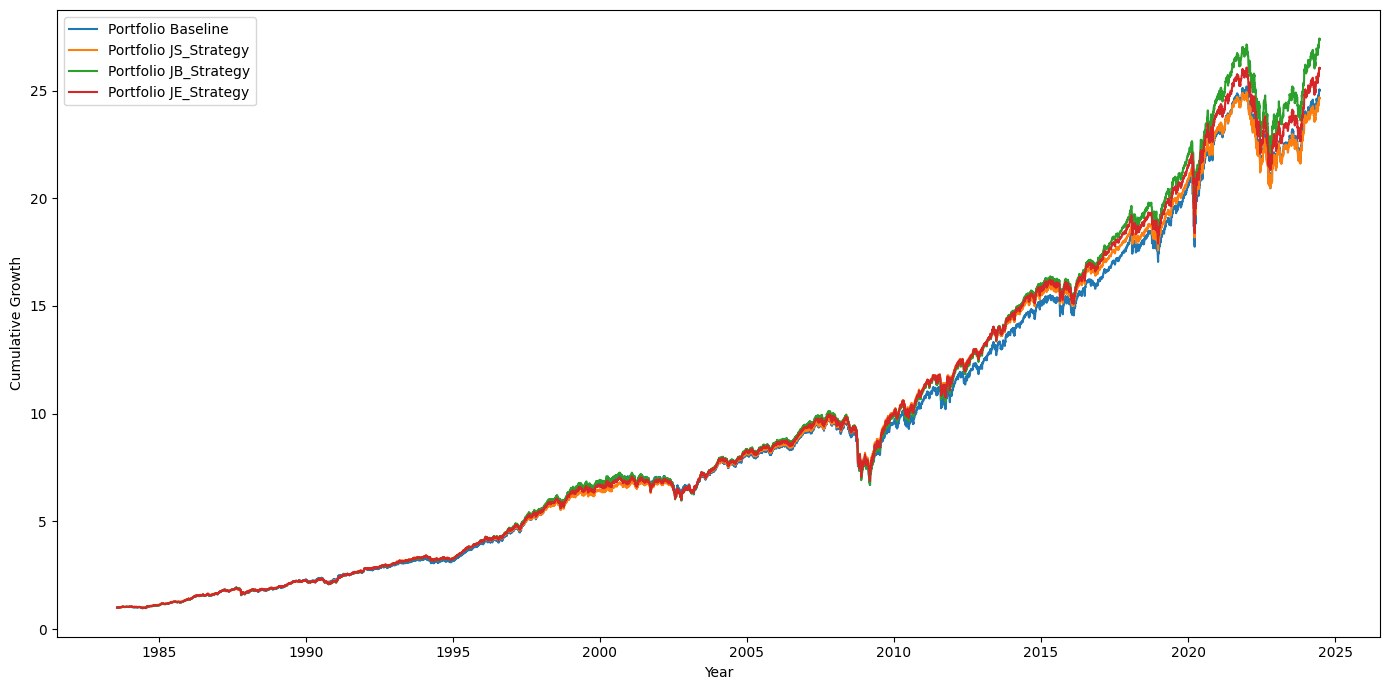

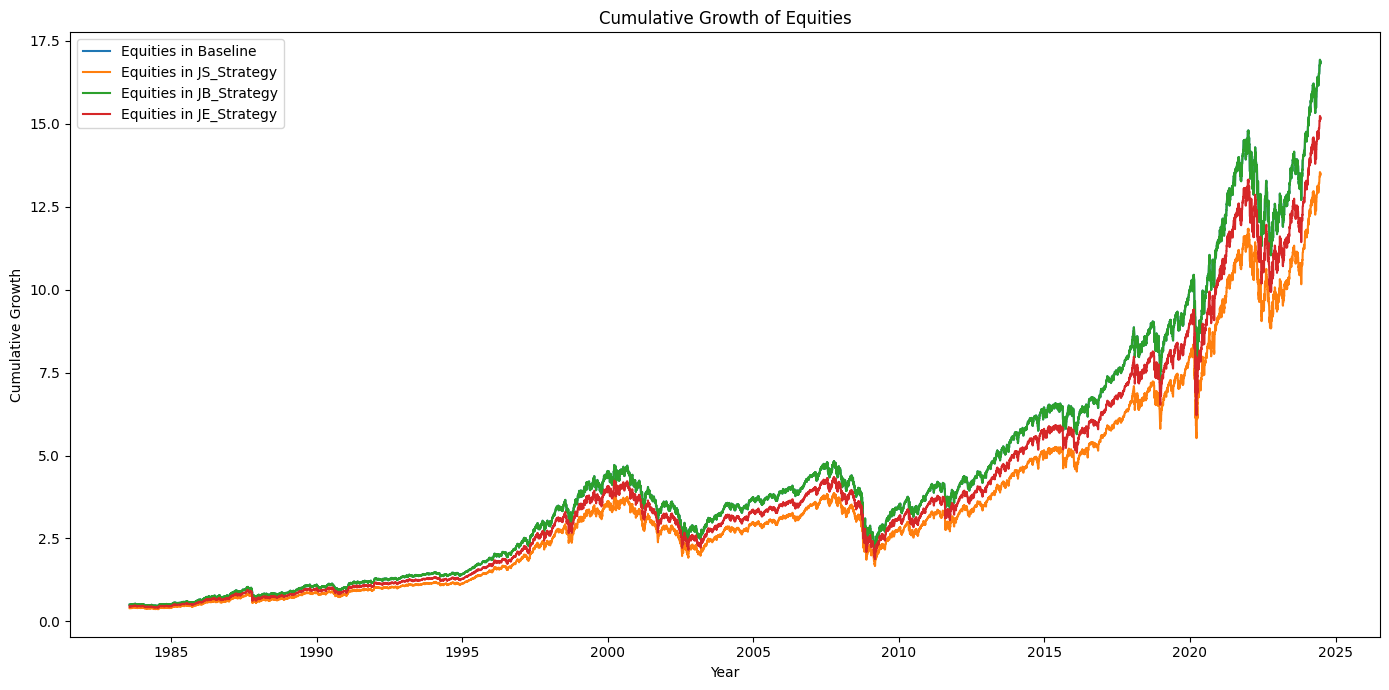

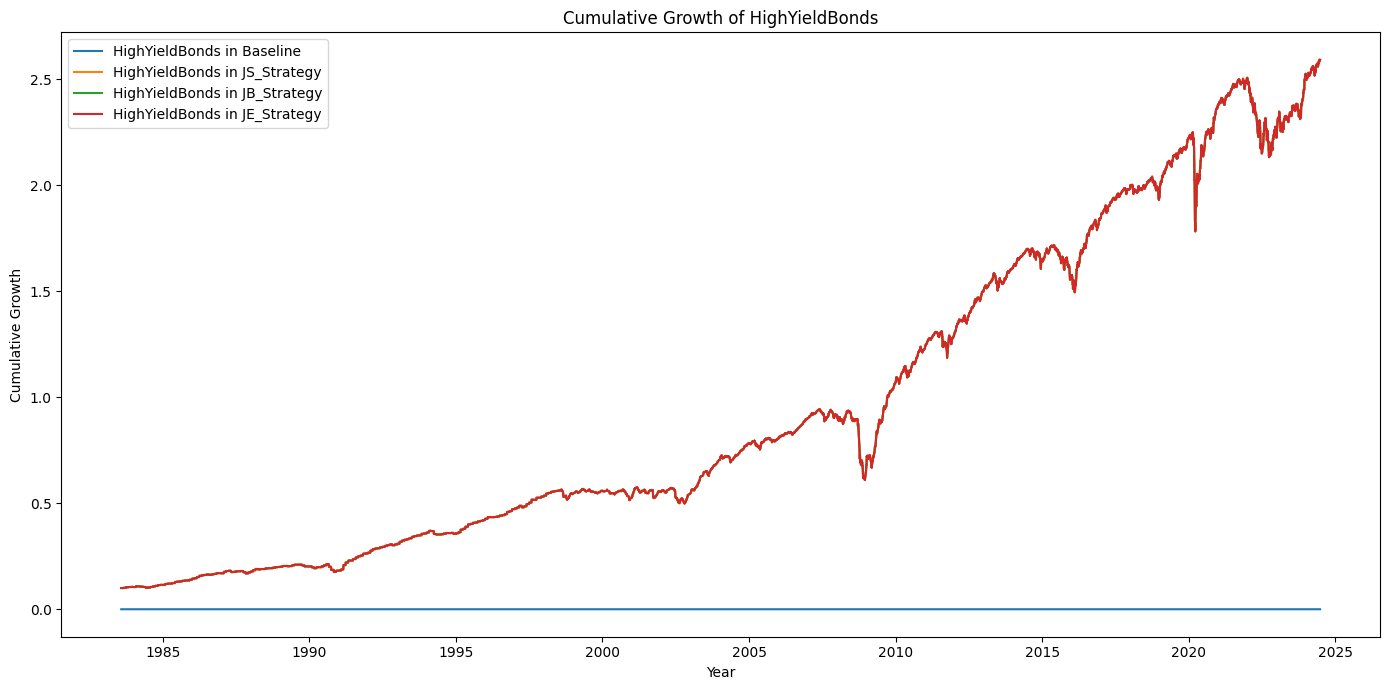

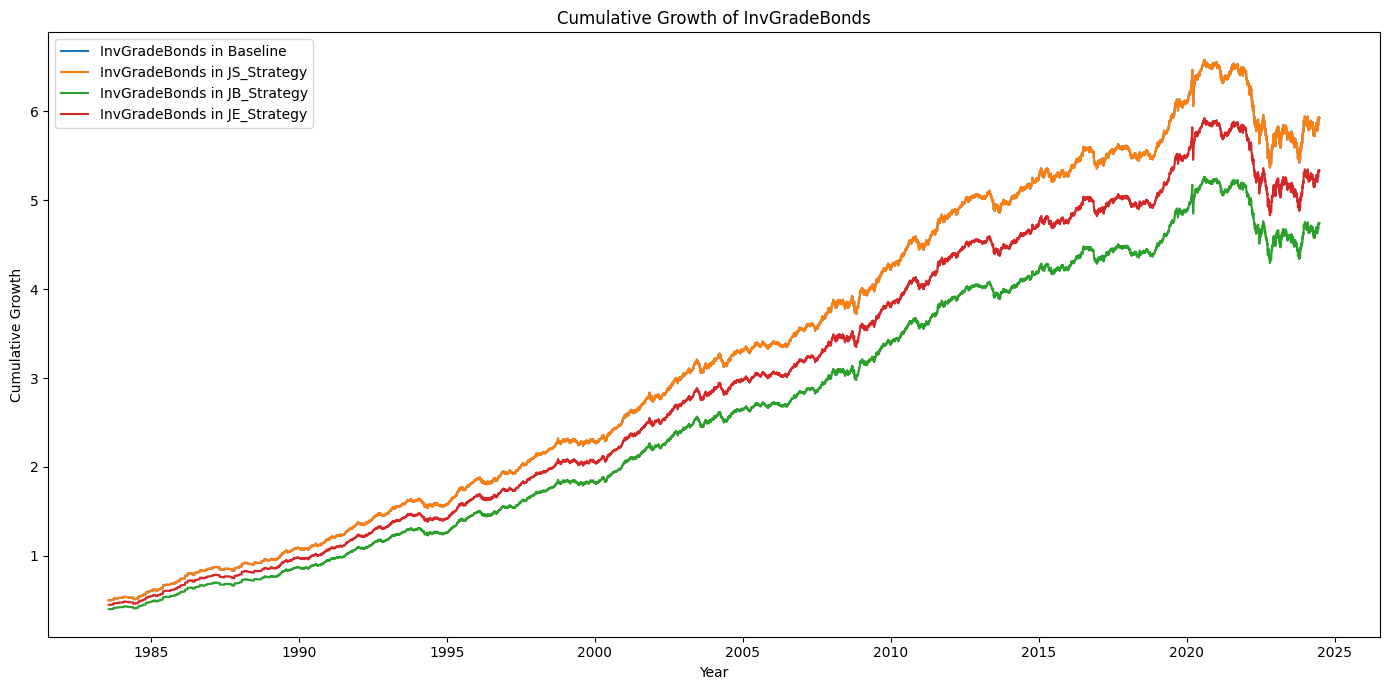

In [12]:
asset_class_cum_ret = backtest_portfolios_asset_class_cum_ret(allocations_df, start_date, end_date, rebalance_freq='6M')

In [13]:
# Extract JB_Strategy returns for each asset class
jb_strategy_returns = {
    'Equities': asset_class_cum_ret['Equities']['JB_Strategy'],
    'HighYieldBonds': asset_class_cum_ret['HighYieldBonds']['JB_Strategy'],
    'InvGradeBonds': asset_class_cum_ret['InvGradeBonds']['JB_Strategy']
}

# Convert the dictionary to a DataFrame
jb_strategy_df = pd.DataFrame(jb_strategy_returns)

In [14]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Get the default colors
default_green = default_colors[2]
default_orange = default_colors[1]
default_blue = default_colors[0]

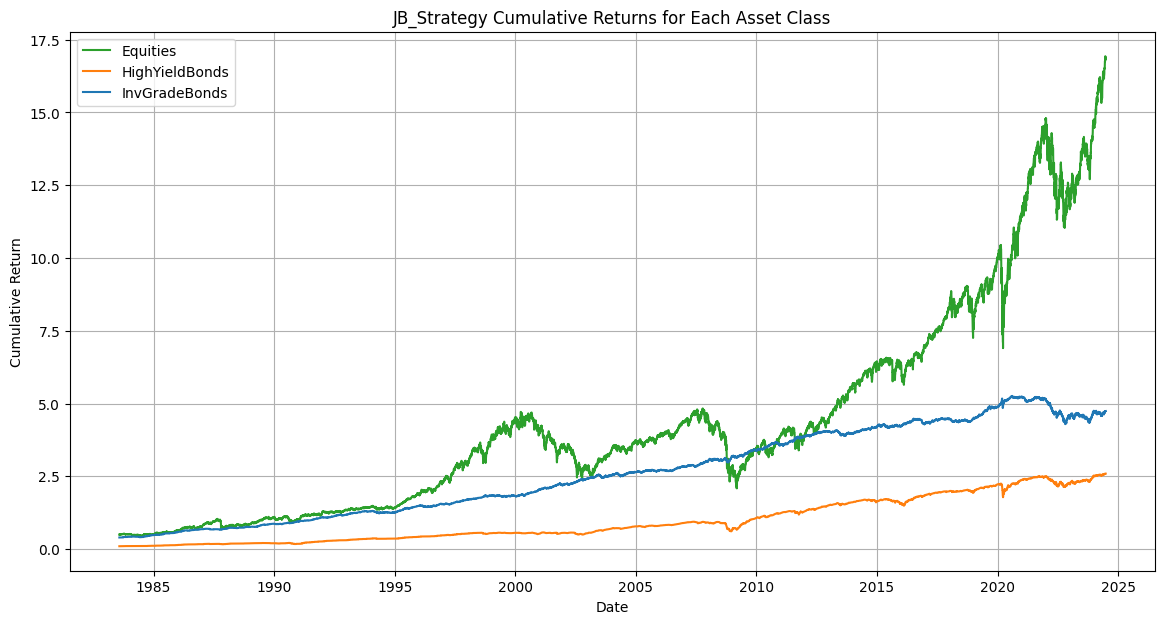

In [15]:
# Plot the JB_Strategy returns for each asset class with default colors
plt.figure(figsize=(14, 7))
colors = {'Equities': default_green, 'HighYieldBonds': default_orange, 'InvGradeBonds': default_blue}
for asset_class in jb_strategy_returns.keys():
    plt.plot(jb_strategy_df.index, jb_strategy_df[asset_class], label=asset_class, color=colors[asset_class])
plt.title('JB_Strategy Cumulative Returns for Each Asset Class')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
jb_strategy_df.iloc[-1]

Equities          16.876389
HighYieldBonds     2.592516
InvGradeBonds      4.740465
Name: 2024-06-25 00:00:00, dtype: float64

In [17]:
# ending total return
jb_strategy_df.iloc[0]


Equities          0.5
HighYieldBonds    0.1
InvGradeBonds     0.4
Name: 1983-08-01 00:00:00, dtype: float64

In [18]:
total_ret = jb_strategy_df.iloc[-1] - jb_strategy_df.iloc[0]
total_ret

Equities          16.376389
HighYieldBonds     2.492516
InvGradeBonds      4.340465
dtype: float64

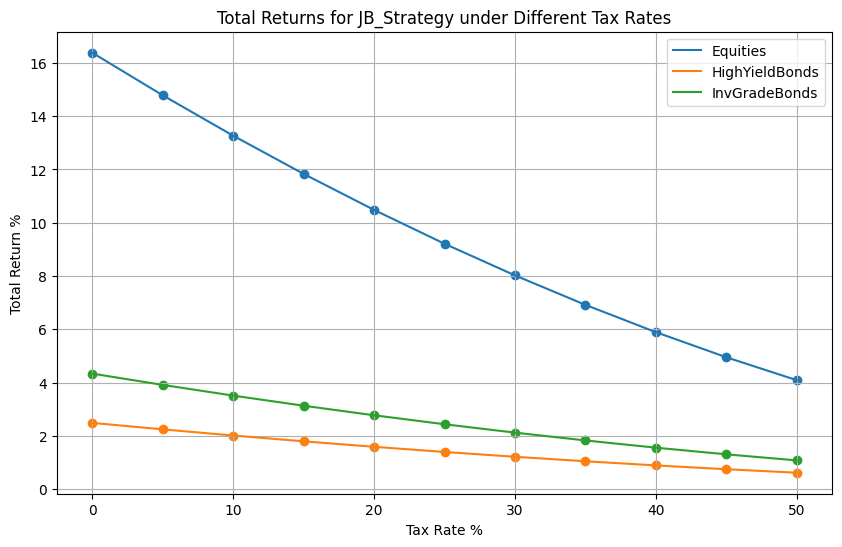

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Define the tax rates to consider
tax_rates = np.arange(0, 51, 5)  # From 0% to 50% in steps of 5%

# Function to calculate after-tax returns
def calculate_after_tax_return(pre_tax_return, tax_rate):
    capital_gains_tax_rate = tax_rate / 100
    regular_income_tax_rate = tax_rate / 100
    after_tax_return = pre_tax_return * (1 - capital_gains_tax_rate) * (1 - regular_income_tax_rate)
    return after_tax_return

# Get the total returns for JB_Strategy
total_returns = total_ret

# Calculate after-tax returns for each tax rate
after_tax_returns = {asset_class: [] for asset_class in total_returns.keys()}
for tax_rate in tax_rates:
    for asset_class, total_return in total_returns.items():
        after_tax_return = calculate_after_tax_return(total_return, tax_rate)
        after_tax_returns[asset_class].append(after_tax_return)

# Plot the results
plt.figure(figsize=(10, 6))
for asset_class, returns in after_tax_returns.items():
    plt.plot(tax_rates, returns, label=asset_class)
    plt.scatter(tax_rates, returns)  # Add dots to the plot

plt.xlabel('Tax Rate %')
plt.ylabel('Total Return %')
plt.title('Total Returns for JB_Strategy under Different Tax Rates')
plt.legend()
plt.grid(True)
plt.show()

Equity
- Capital Gain Tax: Long-term Capital Gains
- Regular Income Tax: Qualified Dividends

Bond
- Interest Income: Ordinary Income Tax
- Capital Gain Tax: similar to equities, bonds sold for a profit are subject to capital gains tax, with short-term and long-term rates depending on the holding period.


In [20]:
starting_balance = 100000
ending_return = 100000 * total_ret
ending_return

Equities          1.637639e+06
HighYieldBonds    2.492516e+05
InvGradeBonds     4.340465e+05
dtype: float64

In [21]:
# Define the options
options = {
    'Option 1': {
        'Tax-Sheltered Account': ['High-Yield Bonds', 'Equities'],
        'Taxable Account': ['Investment-Grade Bonds']
    },
    'Option 2': {
        'Tax-Sheltered Account': ['High-Yield Bonds', 'Investment-Grade Bonds'],
        'Taxable Account': ['Equities']
    },
    'Option 3': {
        'Tax-Sheltered Account': ['Equities', 'Investment-Grade Bonds'],
        'Taxable Account': ['High-Yield Bonds']
    },
    'Option 4': {
        'Tax-Sheltered Account': ['High-Yield Bonds'],
        'Taxable Account': ['Equities', 'Investment-Grade Bonds']
    },
    'Option 5': {
        'Tax-Sheltered Account': ['Equities'],
        'Taxable Account': ['High-Yield Bonds', 'Investment-Grade Bonds']
    },
    'Option 6': {
        'Tax-Sheltered Account': ['Investment-Grade Bonds'],
        'Taxable Account': ['High-Yield Bonds', 'Equities']
    },
    'Option 7': {
        'Tax-Sheltered Account': ['High-Yield Bonds', 'Equities', 'Investment-Grade Bonds'],
        'Taxable Account': []
    },
    'Option 8': {
        'Taxable Account': ['High-Yield Bonds', 'Equities', 'Investment-Grade Bonds'],
        'Tax-Sheltered Account': []
    }
}

# Convert the options dictionary to a DataFrame
options_df = pd.DataFrame.from_dict(options, orient='index')

# Display the DataFrame
options_df

,Tax-Sheltered Account,Taxable Account
Option 1,"[High-Yield Bonds, Equities]",[Investment-Grade Bonds]
Option 2,"[High-Yield Bonds, Investment-Grade Bonds]",[Equities]
Option 3,"[Equities, Investment-Grade Bonds]",[High-Yield Bonds]
Option 4,[High-Yield Bonds],"[Equities, Investment-Grade Bonds]"
Option 5,[Equities],"[High-Yield Bonds, Investment-Grade Bonds]"
Option 6,[Investment-Grade Bonds],"[High-Yield Bonds, Equities]"
Option 7,"[High-Yield Bonds, Equities, Investment-Grade ...",[]
Option 8,[],"[High-Yield Bonds, Equities, Investment-Grade ..."


As a practical matter, most stock dividends in the U.S. qualify to be taxed as capital gains. 

U.S. federal government taxes qualified dividends as capital gains instead of income.

In [ ]:
# https://www.irs.gov/taxtopics/tc409
# Topic no. 409, Capital gains and losses




In [22]:
def calculate_taxable_account_capital_gain()

SyntaxError: expected ':' (994203487.py, line 1)

In [ ]:
def calculate_taxable_account_income()

In [ ]:
def calculate_taxable_account_dividend()

In [ ]:
def calculate_tax_shelter_account_capital_gain()

In [ ]:
def calculate_tax_shelter_account_income()

In [ ]:
def calculate_tax_shelter_dividend()